## Modelling
For this model architecture, we will use autoencoder to forecast energy usage and then the difference between the forecast and the actual usage if cross a certain treshold are tagged as anomaly. 

### How Autoencoder Works 
An autoencoder consists of two main parts:
- Encoder: This part of the network learns to compress the input data into a lower-dimensional representation or latent space. Essentially, the encoder extracts the most important features of the input.
- Decoder: The decoder attempts to reconstruct the input data from the compressed latent representation. It tries to bring the data back to its original form.

<img src="images/autoencoder.png" alt="Autoencoder" style="width: 600px;"/>

During training, the model is trained to minimize the reconstruction error.

### How LSTM Works
LSTM is specifically designed to solve the vanishing gradient problem of traditional RNNs. It can capture both short-term dependencies (recent data points) and long-term dependencies (older but still relevant data points) in sequences. This is achieved through its unique architecture, which includes three key components:
- Input Gate: Controls how much of the current input to allow into the memory cell.
- Forget Gate: Decides which information from the past should be forgotten or retained.
- Output Gate: Determines how much of the memory cell to pass on as output.

<img src="images/LSTM.jpg" alt="LSTM" style="width: 600px;"/>

### Combining Both
To effectively capture both the temporal dependencies in energy usage data and detect anomalies, we use an LSTM Autoencoder. This combines the sequential learning capabilities of LSTMs with the dimensionality reduction and reconstruction features of autoencoders. Here's how the combined architecture works:

- Encoder: The input sequence of energy usage data (e.g., hourly or daily averages) is passed through LSTM layers in the encoder. These layers compress the input sequence into a latent space representation. The LSTM encoder captures patterns and temporal relationships in the data.
- Latent Space: The encoder reduces the input data into a lower-dimensional representation that retains only the most critical information, discarding noise and redundant features.
- Decoder: The latent representation is passed to the LSTM decoder, which attempts to reconstruct the input sequence. This step uses the compressed representation to recreate the original energy usage pattern.
- Reconstruction Error: The reconstructed sequence is compared to the original input sequence, and the difference is calculated as the reconstruction error.
For normal data, the error is low because the model has learned the regular patterns. For anomalies, the reconstruction error is significantly higher, as the model cannot effectively recreate these unseen patterns.

Source (https://doi.org/10.1016/j.ijinfomgt.2020.102282)

<img src="images/LSTM Autoencoder.jpg" alt="LSTM" style="width: 600px;"/>

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
df = pd.read_csv('data/data_predicted.csv')

In [3]:
df

,timestamp,hourly average,usage,hour,year,month,week,weekday,usage_scaled
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0,2024,2,5,3,0.000000
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1,2024,2,5,3,0.005519
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2,2024,2,5,3,0.006099
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3,2024,2,5,3,0.006224
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4,2024,2,5,3,0.005657
...,...,...,...,...,...,...,...,...,...
5025,2024-08-28 09:00:00,4.186957e+07,13.110667,9,2024,8,35,2,0.362667
5026,2024-08-28 10:00:00,4.189131e+07,21.741000,10,2024,8,35,2,0.601399
5027,2024-08-28 11:00:00,4.190912e+07,17.805583,11,2024,8,35,2,0.492537
5028,2024-08-28 12:00:00,4.192575e+07,16.629350,12,2024,8,35,2,0.460000


### Changing Index and Adding Features

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week'] = df.index.isocalendar().week
df['hour'] = df.index.hour

In [6]:
df

,hourly average,usage,hour,year,month,week,weekday,usage_scaled,day
timestamp,,,,,,,,,
2024-02-01 00:00:00,1.955991e+07,0.000000,0,2024,2,5,3,0.000000,1
2024-02-01 01:00:00,1.956011e+07,0.199500,1,2024,2,5,3,0.005519,1
2024-02-01 02:00:00,1.956033e+07,0.220500,2,2024,2,5,3,0.006099,1
2024-02-01 03:00:00,1.956056e+07,0.225000,3,2024,2,5,3,0.006224,1
2024-02-01 04:00:00,1.956076e+07,0.204500,4,2024,2,5,3,0.005657,1
...,...,...,...,...,...,...,...,...,...
2024-08-28 09:00:00,4.186957e+07,13.110667,9,2024,8,35,2,0.362667,28
2024-08-28 10:00:00,4.189131e+07,21.741000,10,2024,8,35,2,0.601399,28
2024-08-28 11:00:00,4.190912e+07,17.805583,11,2024,8,35,2,0.492537,28


## Modelling

Applying normalization on the features because LSTM are sensitive to value mangnitude

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

df['usage_scaled'] = scaler.fit_transform(df[['usage']])

### Convert series to samples 

In [8]:
sequence_length = 24  

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df['usage_scaled'].values, sequence_length)

splitting the dataset

In [9]:
X = X.reshape((X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Model Architecture

In [10]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    RepeatVector(X_train.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mae')

model.summary()

C:\Users\62813\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,937 (968.50 KB)

 Trainable params: 247,937 (968.50 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.1108 - val_loss: 0.1094
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0942 - val_loss: 0.0827
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0683 - val_loss: 0.0519
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0456 - val_loss: 0.0383
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0381 - val_loss: 0.0364
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0340 - val_loss: 0.0313
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0321 - val_loss: 0.0316
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0299 - val_loss: 0.0285
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0286 - val_loss: 0.0289
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0285 - val_loss: 0.0285
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━

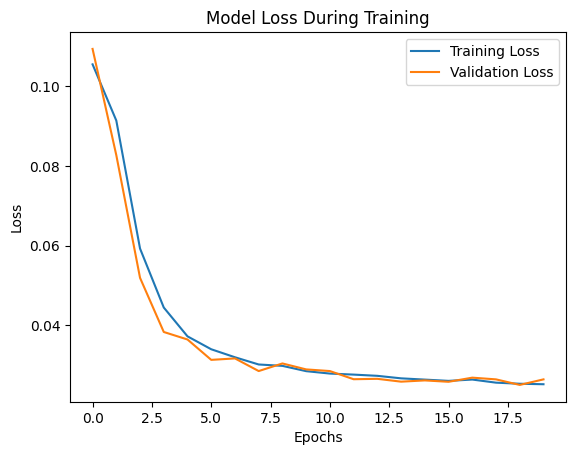

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Define a threshold for anomaly detection (e.g., 95th percentile of training loss)
threshold = np.percentile(test_mae_loss, 99)
print(f"Reconstruction error threshold: {threshold}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Reconstruction error threshold: 0.08092070574747458


In [14]:
anomalies = test_mae_loss > threshold

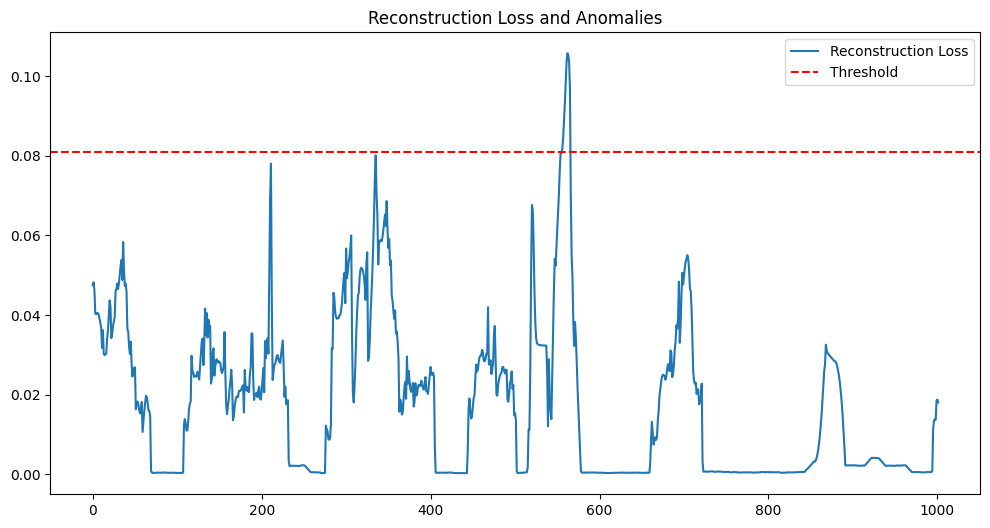

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(test_mae_loss, label='Reconstruction Loss')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('Reconstruction Loss and Anomalies')
plt.show()

In [16]:
data_sequences, _ = create_sequences(df['usage_scaled'].values, sequence_length)
data_sequences = data_sequences.reshape((data_sequences.shape[0], sequence_length, 1))
data_reconstruction = model.predict(data_sequences)
reconstruction_error = np.mean(np.abs(data_reconstruction - data_sequences), axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [17]:
df['reconstruction_error'] = np.nan
df['anomaly'] = False

# Assign reconstruction errors using iloc for positional indexing
df.iloc[sequence_length:, df.columns.get_loc('reconstruction_error')] = reconstruction_error

# Detect anomalies using threshold
df['anomaly'] = df['reconstruction_error'] > threshold

In [18]:
df

,hourly average,usage,hour,year,month,week,weekday,usage_scaled,day,reconstruction_error,anomaly
timestamp,,,,,,,,,,,
2024-02-01 00:00:00,1.955991e+07,0.000000,0,2024,2,5,3,0.000000,1,NaN,False
2024-02-01 01:00:00,1.956011e+07,0.199500,1,2024,2,5,3,0.005519,1,NaN,False
2024-02-01 02:00:00,1.956033e+07,0.220500,2,2024,2,5,3,0.006099,1,NaN,False
2024-02-01 03:00:00,1.956056e+07,0.225000,3,2024,2,5,3,0.006224,1,NaN,False
2024-02-01 04:00:00,1.956076e+07,0.204500,4,2024,2,5,3,0.005657,1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-28 09:00:00,4.186957e+07,13.110667,9,2024,8,35,2,0.362667,28,0.013824,False
2024-08-28 10:00:00,4.189131e+07,21.741000,10,2024,8,35,2,0.601399,28,0.013698,False
2024-08-28 11:00:00,4.190912e+07,17.805583,11,2024,8,35,2,0.492537,28,0.018510,False


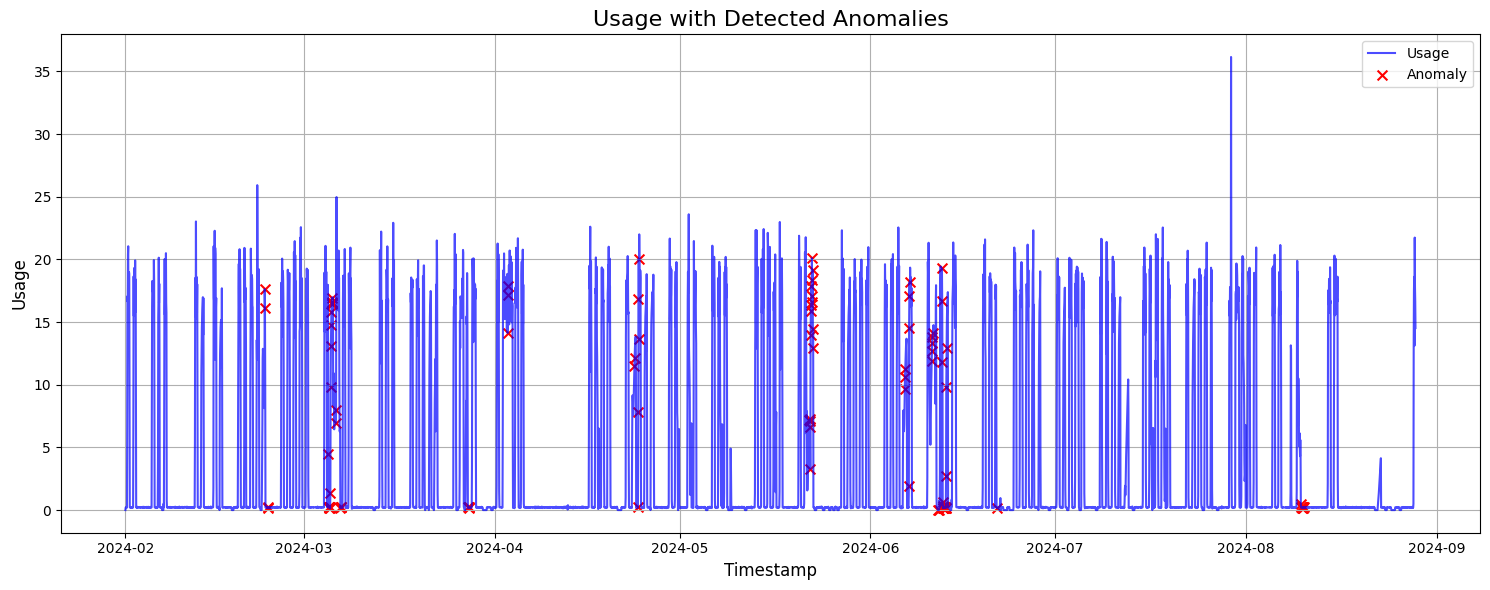

In [19]:
plt.figure(figsize=(15, 6))

plt.plot(df.index, df['usage'], label='Usage', color='blue', alpha=0.7)

plt.scatter(df.index[df['anomaly']], 
            df.loc[df['anomaly'], 'usage'], 
            color='red', label='Anomaly', marker='x', s=50)

# Plot Configuration
plt.title('Usage with Detected Anomalies', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Usage', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()